In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

np.random.seed(1)

# Little boilerplate code to find out if we have a gpu
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


## Siesmic Event Detection

It is a seismic event waveform
The data and label shapes are: (1000, 6000) (1000,)


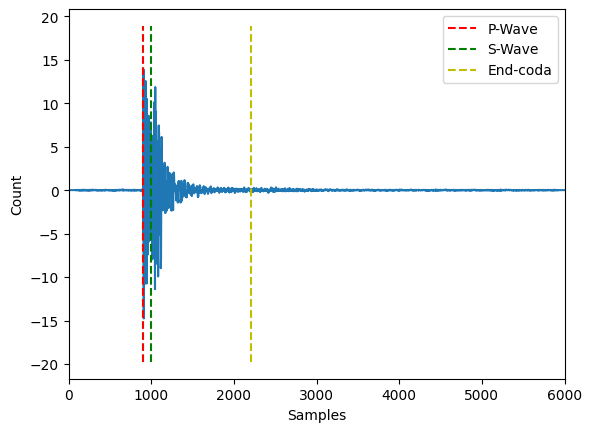

In [2]:
import numpy as np

# Loading data
Seismic_Data = np.load('./data/SeismicEvents_Classification/SiesmicEventsDetectionPicking_Normalized.npz',allow_pickle=True)
data = Seismic_Data['data']
label = Seismic_Data['label']
Pwave = Seismic_Data['P']
Swave = Seismic_Data['S']
Endcoda = Seismic_Data['E']

#Ploting an example
k = 67
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.vlines(Pwave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='r', linestyle='--', label='P-Wave')
plt.vlines(Swave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='g', linestyle='--', label='S-Wave')
plt.vlines(Endcoda[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='y', linestyle='--', label='End-coda')

plt.legend()

# Checking the label
if label[k]==0:
    print('It is a noise waveform')
else:
    print('It is a seismic event waveform')
    
print('The data and label shapes are:',data.shape,label.shape)


## Preparing Label Data for Detection (Sample-based)

In [3]:
Lab_Detection = np.zeros_like(data)
for i,j in enumerate(label):
    #Label for seismic event waveform
    if j==1:
        Lab_Detection[i,Pwave[i]:Endcoda[i]] =1
    #Label for noise waveform
    # Nothingto do since the label should be zero

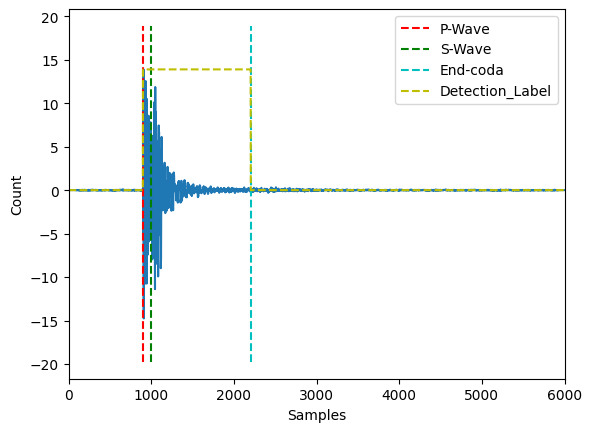

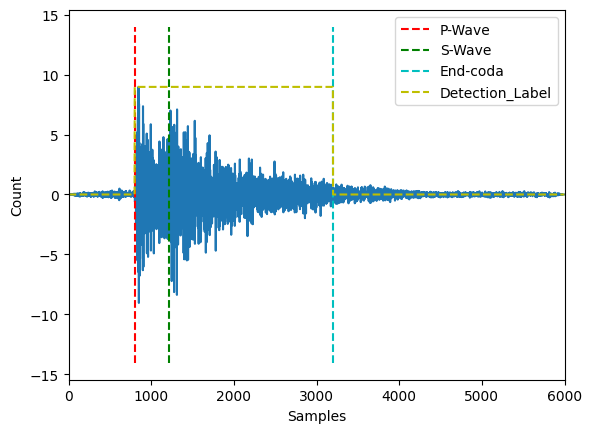

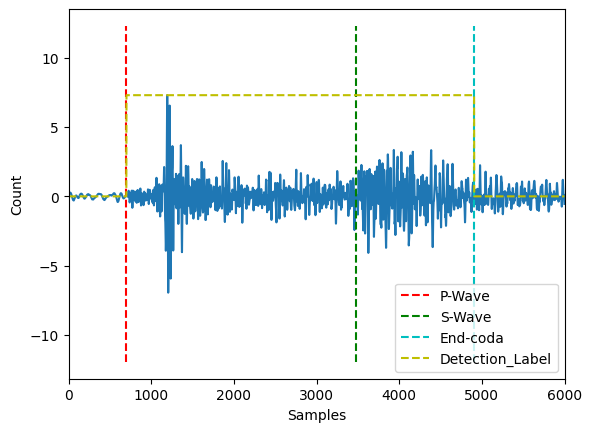

In [4]:
#Ploting event example
k = 67
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.vlines(Pwave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='r', linestyle='--', label='P-Wave')
plt.vlines(Swave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='g', linestyle='--', label='S-Wave')
plt.vlines(Endcoda[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='c', linestyle='--', label='End-coda')
plt.plot(data[k].max()*Lab_Detection[k], color='y', linestyle='--', label='Detection_Label')
plt.legend()


#Ploting event example
k = 66
plt.figure()
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.vlines(Pwave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='r', linestyle='--', label='P-Wave')
plt.vlines(Swave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='g', linestyle='--', label='S-Wave')
plt.vlines(Endcoda[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='c', linestyle='--', label='End-coda')
plt.plot(data[k].max()*Lab_Detection[k], color='y', linestyle='--', label='Detection_Label')
plt.legend()

#Ploting event example
k = 55
plt.figure()
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.vlines(Pwave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='r', linestyle='--', label='P-Wave')
plt.vlines(Swave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='g', linestyle='--', label='S-Wave')
plt.vlines(Endcoda[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='c', linestyle='--', label='End-coda')
plt.plot(data[k].max()*Lab_Detection[k], color='y', linestyle='--', label='Detection_Label')
plt.legend()


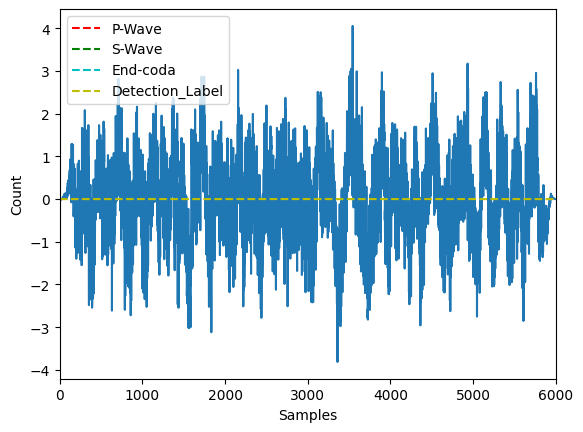

In [5]:
#Ploting noise waveform
k = 87
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.vlines(Pwave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='r', linestyle='--', label='P-Wave')
plt.vlines(Swave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='g', linestyle='--', label='S-Wave')
plt.vlines(Endcoda[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='c', linestyle='--', label='End-coda')
plt.plot(data[k].max()*Lab_Detection[k], color='y', linestyle='--', label='Detection_Label')
plt.legend()




## Data preparation

In [6]:
from torch.utils.data import Dataset, DataLoader

# 1. Define your Dataset class (if you haven't already):

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
        self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [7]:
from sklearn.model_selection import train_test_split

batch_size = 8
# data and labels to tensor
datainput = torch.tensor(data,dtype=torch.float32)
labelout = torch.tensor(Lab_Detection,dtype=torch.float32)


# Divide the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    datainput, labelout, test_size=0.1, random_state=42)

# Create your Dataset instance
dataset_train = MyDataset(train_data, train_labels)
dataset_test  = MyDataset(test_data, test_labels)

# Create a DataLoader
# Adjust batch_size as needed; shuffle=True for training

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

/tmp/ipykernel_3723980/1364125503.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
/tmp/ipykernel_3723980/1364125503.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification


## Create Model Class

In [8]:
import torch.nn as nn
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim1) 
        # Non-linearity
        self.ac1 = nn.ReLU()
        
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  
        # Non-linearity
        self.ac2 = nn.ReLU()
    
        # Linear function (readout)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)  
        # Non-linearity
        self.ac3 = nn.ReLU()
        
        # Linear function (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)  
        # Non-linearity
        self.ac4 = nn.Sigmoid()
        
        
    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)
        # Non-linearity  # NON-LINEAR
        out = self.ac1(out)
        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        # Non-linearity
        out = self.ac2(out)
        # Linear function (readout)  # LINEAR
        out = self.fc3(out)
        # Non-linearity
        out = self.ac3(out)
        # Linear function (readout)  # LINEAR
        out = self.fc4(out)
        # Non-linearity
        out = self.ac4(out)
        
        return out


## Training Process

In [9]:

input_dim = 6000*1
hidden_dim1 = 32
hidden_dim2 = 64
hidden_dim3 = 128
output_dim = 6000

model = FeedforwardNeuralNetModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim).to(device)
print(model)


criterion = nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
model.train()

# Threshold
TH = 0.5

num_epochs = 100

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 6000*1).requires_grad_(True).to(device)
        labels = labels.view(-1, 6000*1).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        

        # Get predictions from the maximum value
        predicted = np.where(outputs.detach().cpu().numpy() > TH, 1, 0)
        


    
            
    # Print Loss
    print('epoch: {}. Loss: {}'.format(epoch, loss.item()))
    


FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=6000, out_features=32, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (ac3): ReLU()
  (fc4): Linear(in_features=128, out_features=6000, bias=True)
  (ac4): Sigmoid()
)
epoch: 0. Loss: 0.34055155515670776
epoch: 1. Loss: 0.24063073098659515
epoch: 2. Loss: 0.2090010941028595
epoch: 3. Loss: 0.2641790211200714
epoch: 4. Loss: 0.21021759510040283
epoch: 5. Loss: 0.03771931678056717
epoch: 6. Loss: 0.021206863224506378
epoch: 7. Loss: 0.05276647210121155
epoch: 8. Loss: 0.03743358701467514
epoch: 9. Loss: 0.04117888957262039
epoch: 10. Loss: 0.0001199046237161383
epoch: 11. Loss: 0.0893714502453804
epoch: 12. Loss: 0.056725069880485535
epoch: 13. Loss: 0.0061534857377409935
epoch: 14. Loss: 0.04067348316311836
epoch: 15. Loss: 0.042515188455581665
epoch: 16. Loss: 0.06933892518281937
epoch: 17. Loss: 0.077003613114357


## Inference (Testing)

In [10]:
laball = []
preall = []
dat = []
outputsall= []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 6000*1).requires_grad_(True).to(device)
    labels = labels.view(-1, 6000*1).to(device)
        
    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    predicted = np.where(outputs.detach().cpu().numpy() > TH, 1, 0)

    
    laball.append(labels.cpu().numpy())
    preall.append(predicted)
    dat.append(images.detach().cpu().numpy())
    outputsall.append(outputs.detach().cpu().numpy())
    

preall = np.concatenate(preall)
outputsall = np.concatenate(outputsall)
laball = np.concatenate(laball)
dat = np.concatenate(dat)

# Print Loss
print('Loss: {}'.format(loss.item()))

Loss: 0.015903694555163383


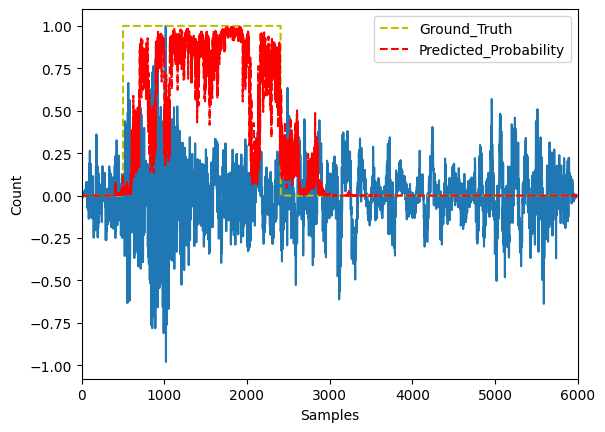

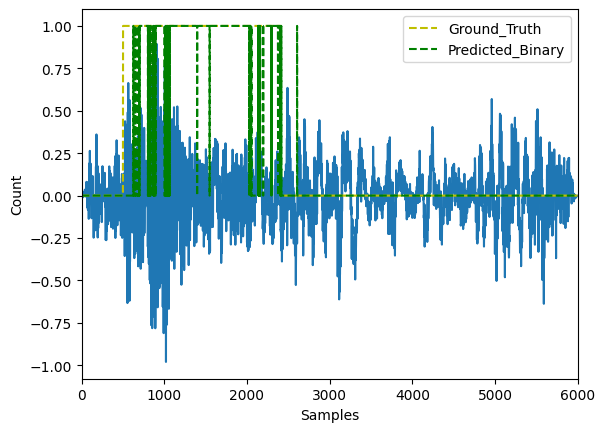

In [11]:
#Ploting an example
k = 18
X = dat[k]/dat[k].max()
Y = laball[k]
Q = preall[k]
Z = outputsall[k]

plt.figure()
plt.plot(X)
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Y, color='y', linestyle='--', label='Ground_Truth')
plt.plot(Z, color='r', linestyle='--', label='Predicted_Probability')
plt.legend()


plt.figure()
plt.plot(X)
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Y, color='y', linestyle='--', label='Ground_Truth')
plt.plot(Q, color='g', linestyle='--', label='Predicted_Binary')
plt.legend()


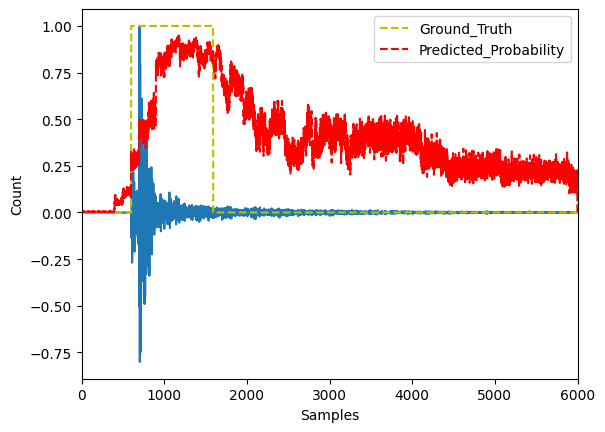

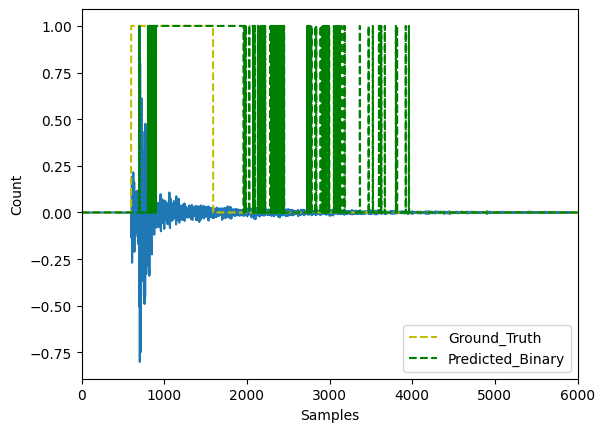

In [12]:
#Ploting an example
k = 20
X = dat[k]/dat[k].max()
Y = laball[k]
Q = preall[k]
Z = outputsall[k]

plt.figure()
plt.plot(X)
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Y, color='y', linestyle='--', label='Ground_Truth')
plt.plot(Z, color='r', linestyle='--', label='Predicted_Probability')
plt.legend()


plt.figure()
plt.plot(X)
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Y, color='y', linestyle='--', label='Ground_Truth')
plt.plot(Q, color='g', linestyle='--', label='Predicted_Binary')
plt.legend()


## Siesmic Event Picking

It is a seismic event waveform
The data and label shapes are: (1000, 6000) (1000,)


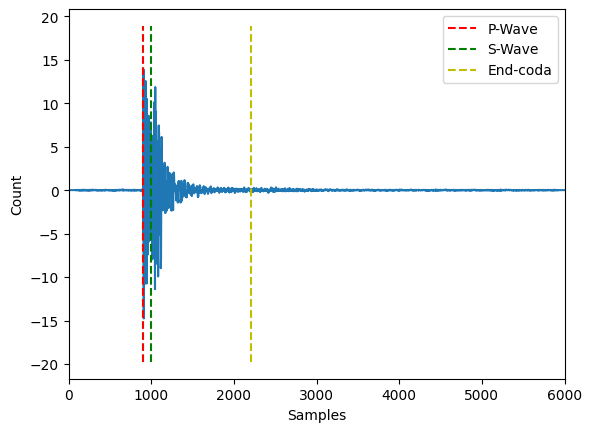

In [13]:
import numpy as np

# Loading data
Seismic_Data = np.load('./data/SeismicEvents_Classification/SiesmicEventsDetectionPicking_Normalized.npz',allow_pickle=True)
data = Seismic_Data['data']
label = Seismic_Data['label']
Pwave = Seismic_Data['P']
Swave = Seismic_Data['S']
Endcoda = Seismic_Data['E']

#Ploting an example
k = 67
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.vlines(Pwave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='r', linestyle='--', label='P-Wave')
plt.vlines(Swave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='g', linestyle='--', label='S-Wave')
plt.vlines(Endcoda[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='y', linestyle='--', label='End-coda')

plt.legend()

# Checking the label
if label[k]==0:
    print('It is a noise waveform')
else:
    print('It is a seismic event waveform')
    
print('The data and label shapes are:',data.shape,label.shape)


## Preparing Label Data for Picking

In [14]:
Lab_Detection = np.zeros_like(data)
halfwidth = 40
dim = Lab_Detection.shape[1]

for i,j in enumerate(label):
    #Label for seismic event waveform
    if j==1:
        spt = Pwave[i]
        if spt and (spt-halfwidth >= 0) and (spt+halfwidth < dim):
            Lab_Detection[i, spt-halfwidth:spt+halfwidth] = np.exp(-(np.arange(spt-halfwidth,spt+halfwidth)-spt)**2/(2*(10)**2))[:dim-(spt-halfwidth)]                
        elif spt and (spt-halfwidth < dim):
            Lab_Detection[i, 0:spt+halfwidth] = np.exp(-(np.arange(0,spt+halfwidth)-spt)**2/(2*(10)**2))[:dim-(spt-halfwidth)]

    #Label for noise waveform
    # Nothingto do since the label should be zero

Pwave Sample is: 800


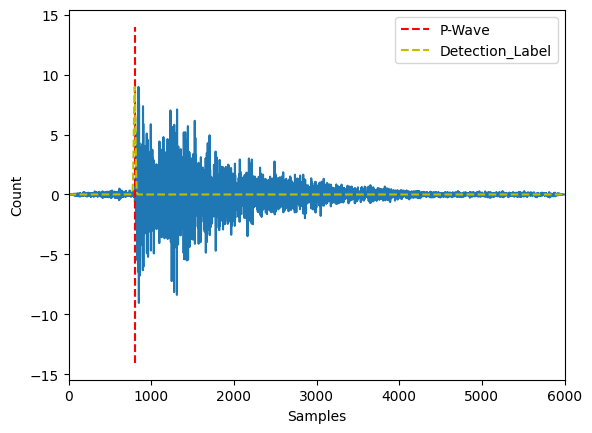

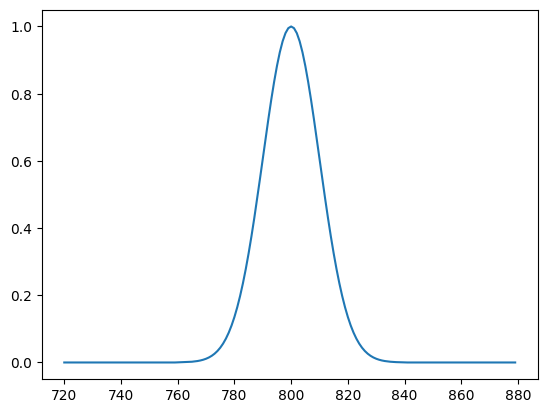

In [15]:
#Ploting event example
k = 66
plt.figure()
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.vlines(Pwave[k],ymin=data[k].min()-5, ymax=data[k].max()+5, color='r', linestyle='--', label='P-Wave')
plt.plot(data[k].max()*Lab_Detection[k], color='y', linestyle='--', label='Detection_Label')
plt.legend()


plt.figure()
Xrange = np.arange(Pwave[k]-2*halfwidth,Pwave[k]+2*halfwidth)
plt.plot(Xrange,Lab_Detection[k,Pwave[k]-2*halfwidth:Pwave[k]+2*halfwidth])
print('Pwave Sample is:', Pwave[k])

## Data preparation


In [16]:
from sklearn.model_selection import train_test_split

batch_size = 8
# data and labels to tensor
datainput = torch.tensor(data,dtype=torch.float32)
labelout = torch.tensor(Lab_Detection,dtype=torch.float32)


# Divide the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    datainput, labelout, test_size=0.1, random_state=42)

# Create your Dataset instance
dataset_train = MyDataset(train_data, train_labels)
dataset_test  = MyDataset(test_data, test_labels)

# Create a DataLoader
# Adjust batch_size as needed; shuffle=True for training

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

/tmp/ipykernel_3723980/1364125503.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
/tmp/ipykernel_3723980/1364125503.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification


## Create Model Class

In [17]:
import torch.nn as nn
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim1) 
        # Non-linearity
        self.ac1 = nn.ReLU()
        
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  
        # Non-linearity
        self.ac2 = nn.ReLU()
    
        # Linear function (readout)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)  
        # Non-linearity
        self.ac3 = nn.ReLU()
        
        # Linear function (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)  
        # Non-linearity
        self.ac4 = nn.Sigmoid()
        
        
    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)
        # Non-linearity  # NON-LINEAR
        out = self.ac1(out)
        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        # Non-linearity
        out = self.ac2(out)
        # Linear function (readout)  # LINEAR
        out = self.fc3(out)
        # Non-linearity
        out = self.ac3(out)
        # Linear function (readout)  # LINEAR
        out = self.fc4(out)
        # Non-linearity
        out = self.ac4(out)
        
        return out


## Training Process

In [18]:

input_dim = 6000*1
hidden_dim1 = 32
hidden_dim2 = 64
hidden_dim3 = 128
output_dim = 6000

model = FeedforwardNeuralNetModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim).to(device)
print(model)


criterion = nn.BCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
model.train()

# Threshold
TH = 0.5

num_epochs = 100

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 6000*1).requires_grad_(True).to(device)
        labels = labels.view(-1, 6000*1).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        

        # Get predictions from the maximum value
        predicted = np.where(outputs.detach().cpu().numpy() > TH, 1, 0)
        


    
            
    # Print Loss
    print('epoch: {}. Loss: {}'.format(epoch, loss.item()))
    


FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=6000, out_features=32, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (ac3): ReLU()
  (fc4): Linear(in_features=128, out_features=6000, bias=True)
  (ac4): Sigmoid()
)
epoch: 0. Loss: 0.012777026742696762
epoch: 1. Loss: 0.008180566132068634
epoch: 2. Loss: 0.009547225199639797
epoch: 3. Loss: 0.0057983677834272385
epoch: 4. Loss: 0.0059350840747356415
epoch: 5. Loss: 0.0052168783731758595
epoch: 6. Loss: 0.004243586212396622
epoch: 7. Loss: 0.008138504810631275
epoch: 8. Loss: 0.0033066326286643744
epoch: 9. Loss: 0.009636983275413513
epoch: 10. Loss: 0.0002627312787808478
epoch: 11. Loss: 0.008695603348314762
epoch: 12. Loss: 0.0030253587756305933
epoch: 13. Loss: 0.0035726509522646666
epoch: 14. Loss: 0.0020662101451307535
epoch: 15. Loss: 0.0021618134342134
epoch: 16. Loss: 0.003645905526354909
epoch: 17. Loss:

## Inference (Test)

In [19]:
laball = []
preall = []
dat = []
outputsall= []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 6000*1).requires_grad_(True).to(device)
    labels = labels.view(-1, 6000*1).to(device)
        
    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    predicted = np.where(outputs.detach().cpu().numpy() > TH, 1, 0)

    
    laball.append(labels.cpu().numpy())
    preall.append(predicted)
    dat.append(images.detach().cpu().numpy())
    outputsall.append(outputs.detach().cpu().numpy())
    

preall = np.concatenate(preall)
outputsall = np.concatenate(outputsall)
laball = np.concatenate(laball)
dat = np.concatenate(dat)

# Print Loss
print('Loss: {}'.format(loss.item()))

Loss: 0.003918829374015331


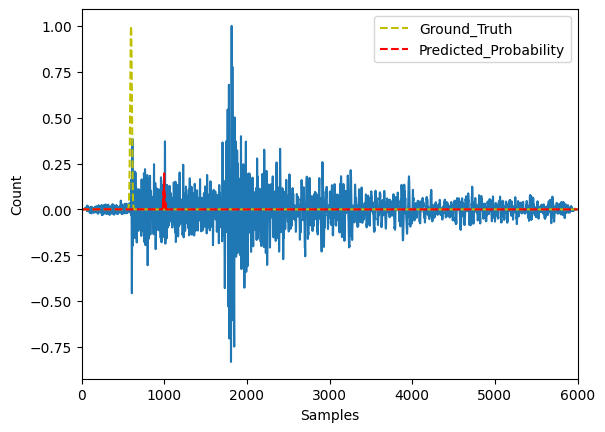

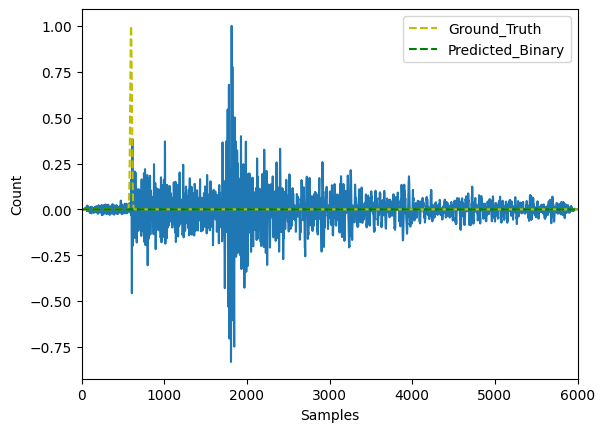

In [20]:
#Ploting an example
k = 94
X = dat[k]/dat[k].max()
Y = laball[k]
Q = preall[k]
Z = outputsall[k]

plt.figure()
plt.plot(X)
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Y, color='y', linestyle='--', label='Ground_Truth')
plt.plot(Z, color='r', linestyle='--', label='Predicted_Probability')
plt.legend()


plt.figure()
plt.plot(X)
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Y, color='y', linestyle='--', label='Ground_Truth')
plt.plot(Q, color='g', linestyle='--', label='Predicted_Binary')
plt.legend()


In [21]:
# Picking the P-wave arrival time
P_wave_Pred = preall.argmax(axis=-1)
P_wave_True = laball.argmax(axis=-1)

pwave = []
pwavetp=[]
pwavetn=[]
pwavefp=[]
pwavefn=[]
fals=[]

for iq in range(len(P_wave_True)):
    
    if (P_wave_Pred[iq]!=0) and (P_wave_True[iq]!=0):
        pwavetp.append(P_wave_True[iq]-P_wave_Pred[iq])
        
    elif (P_wave_Pred[iq]==0) and (P_wave_True[iq]!=0):
        pwavefn.append(iq)
        
    elif (P_wave_Pred[iq]==0) and (P_wave_True[iq]==0):
        pwavetn.append(iq)
    
    elif (P_wave_Pred[iq]!=0) and (P_wave_True[iq]==0):
        pwavefp.append(iq)
        fals.append(iq)



samp = 50
diftp = np.array(pwavetp)
TP = len(diftp)
TN = len(pwavetn) 
FP = len(pwavefp) 
FN = len(pwavefn) + len(np.where(np.abs(diftp)>samp)[0])
P = TP /(TP+FP)
R = TP / (TP+FN)
F1 = 2 * (P*R) / (P+R)

print('Total number of tested events is:',len(P_wave_Pred))
print('TP is:',TP)
print('FP is:',FP)
print('TN is:',TN)
print('FN is:',FN)
print('Precision is:',P)
print('Recall is :',R)
print("F1-score is:",F1)
print('Number of missing Events is:',len(pwavefn))
print('Number of Picked Event with error >0.5:',len(np.where(np.abs(diftp)>samp)[0]))
a0 = np.where(np.abs(diftp)<=samp)[0]
diftpp = diftp[a0]/100
print('std is:',np.std(diftpp))
print('MAE is:',np.mean(np.abs(diftpp)))


Total number of tested events is: 100
TP is: 23
FP is: 25
TN is: 25
FN is: 46
Precision is: 0.4791666666666667
Recall is : 0.3333333333333333
F1-score is: 0.39316239316239315
Number of missing Events is: 27
Number of Picked Event with error >0.5: 19
std is: 0.050682837331783234
MAE is: 0.0675


## Self-supervised Seismic Event Classification

It is a seismic event waveform
The data and label shapes are: (1000, 6000) (1000,)


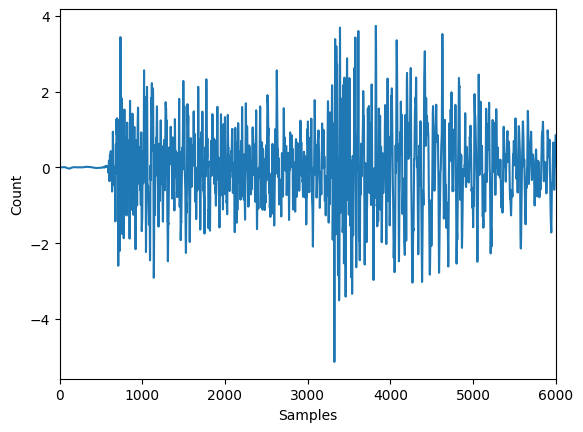

In [3]:
# Loading data
Seismic_Data = np.load('./data/SeismicEvents_Classification/SiesmicEventsClassification_Normalized.npz')
data = Seismic_Data['data']
label = Seismic_Data['label']

# Compute the absolute maximum for each sample along axis 1
#abs_max = np.max(np.abs(data1), axis=1, keepdims=True)
# Normalize each sample by its absolute maximum
#data = data1 / abs_max

#Ploting an example
fig = plt.plot()
k = 97
plt.plot(data[k])
plt.xlim([0,len(data[k])])
plt.xlabel('Samples')
plt.ylabel('Count')

# Checking the label
if label[k]==0:
    print('It is a noise waveform')
else:
    print('It is a seismic event waveform')
    
print('The data and label shapes are:',data.shape,label.shape)


## Data preparation

In [4]:
from torch.utils.data import Dataset, DataLoader

# 1. Define your Dataset class (if you haven't already):

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
        self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [5]:
from sklearn.model_selection import train_test_split

batch_size = 8
# data and labels to tensor
datainput = torch.tensor(data,dtype=torch.float32)
labelout = torch.tensor(label,dtype=torch.float32)


# Divide the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(
    datainput, datainput, test_size=0.1, random_state=42)

# Create your Dataset instance
dataset_train = MyDataset(train_data, train_labels)
dataset_test  = MyDataset(test_data, test_labels)

# Create a DataLoader
# Adjust batch_size as needed; shuffle=True for training

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

/tmp/ipykernel_3797936/1364125503.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)  # Convert to torch tensor
/tmp/ipykernel_3797936/1364125503.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32) #Convert labels to long for classification


In [23]:
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, bottleneck_dim, output_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim1)
        self.encoder_ac1 = nn.LeakyReLU(0.5)
        
        self.encoder_fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.encoder_ac2 = nn.LeakyReLU(0.5)
        
        self.encoder_bottleneck = nn.Linear(hidden_dim2, bottleneck_dim)
        self.encoder_bottleneck_ac =  nn.LeakyReLU(0.5)

        # Decoder
        self.decoder_fc1 = nn.Linear(bottleneck_dim, hidden_dim2)
        self.decoder_ac1 = nn.LeakyReLU(0.5)
        
        self.decoder_fc2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.decoder_ac2 = nn.LeakyReLU(0.5)
        
        self.decoder_fc3 = nn.Linear(hidden_dim1, output_dim)
        #self.decoder_ac4 = nn.Tanh()

    def forward(self, x):
        # Encoding
        E1 = self.encoder_fc1(x)
        E1 = self.encoder_ac1(E1)
        E2 = self.encoder_fc2(E1)
        E2 = self.encoder_ac2(E2)
        
        # Bottle-neck
        E3 = self.encoder_bottleneck(E2)
        E3 = self.encoder_bottleneck_ac(E3)
        
        # Decoding
        D1 = self.decoder_fc1(E3)
        D1 = self.decoder_ac1(D1)
        #D1 = D1 + E2
        D2 = self.decoder_fc2(D1)
        D2 = self.decoder_ac2(D2)
        #D2 = D2 + E1
        
        out = self.decoder_fc3(D2)
        #out = self.decoder_ac4(out)
        
        return E3,out

In [24]:

input_dim = 6000*1
hidden_dim1 = 1000
hidden_dim2 = 500
bottleneck_dim = 128
output_dim = 6000

model = Autoencoder(input_dim, hidden_dim1, hidden_dim2, bottleneck_dim, output_dim).to(device)
print(model)


criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
model.train()
num_epochs = 100

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 6000*1).requires_grad_(True).to(device)
        labels = labels.view(-1, 6000*1).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        E, outputs = model(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
    
            
    # Print Loss
    print('epoch: {}. Loss: {}'.format(epoch, loss.item()))
    


Autoencoder(
  (encoder_fc1): Linear(in_features=6000, out_features=1000, bias=True)
  (encoder_ac1): LeakyReLU(negative_slope=0.5)
  (encoder_fc2): Linear(in_features=1000, out_features=500, bias=True)
  (encoder_ac2): LeakyReLU(negative_slope=0.5)
  (encoder_bottleneck): Linear(in_features=500, out_features=128, bias=True)
  (encoder_bottleneck_ac): LeakyReLU(negative_slope=0.5)
  (decoder_fc1): Linear(in_features=128, out_features=500, bias=True)
  (decoder_ac1): LeakyReLU(negative_slope=0.5)
  (decoder_fc2): Linear(in_features=500, out_features=1000, bias=True)
  (decoder_ac2): LeakyReLU(negative_slope=0.5)
  (decoder_fc3): Linear(in_features=1000, out_features=6000, bias=True)
)
epoch: 0. Loss: 0.9989545941352844
epoch: 1. Loss: 0.9816586971282959
epoch: 2. Loss: 0.9690393209457397
epoch: 3. Loss: 0.9096707105636597
epoch: 4. Loss: 0.8905267715454102
epoch: 5. Loss: 0.8749353885650635
epoch: 6. Loss: 0.9078884720802307
epoch: 7. Loss: 0.7197688817977905
epoch: 8. Loss: 0.814469575

In [25]:
laball = []
dat = []
outputsall= []
Eall = []
# Iterate through test dataset
for images, labels in test_loader:
    # Load images with gradient accumulation capabilities
    images = images.view(-1, 6000*1).requires_grad_(True).to(device)
    labels = labels.view(-1, 6000*1).to(device)
        
    # Forward pass only to get logits/output
    E, outputs = model(images)

    
    laball.append(labels.cpu().numpy())
    dat.append(images.detach().cpu().numpy())
    outputsall.append(outputs.detach().cpu().numpy())
    Eall.append(E.detach().cpu().numpy())

    

outputsall = np.concatenate(outputsall)
laball = np.concatenate(laball)
dat = np.concatenate(dat)
Eall = np.concatenate(Eall)

# Print Loss
print('Loss: {}'.format(loss.item()))

Loss: 0.23501096665859222


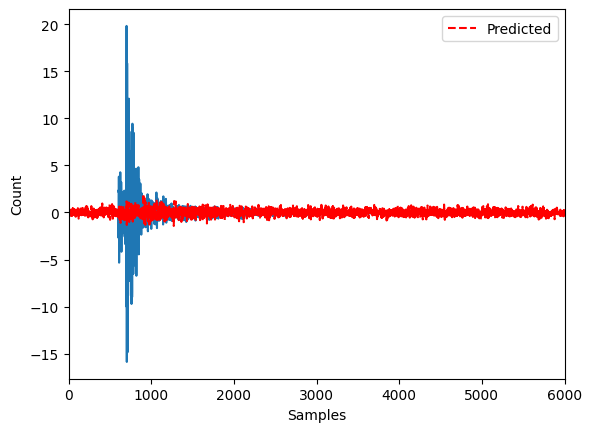

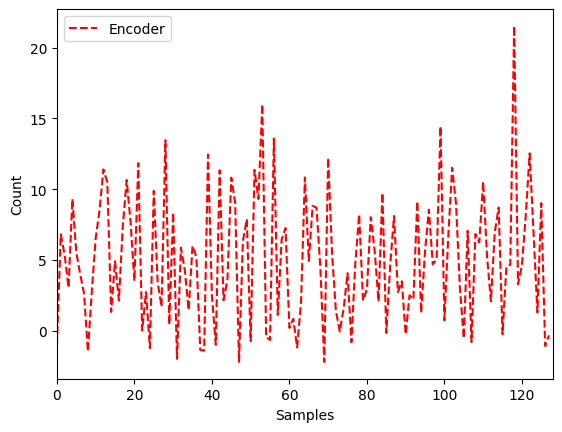

In [27]:
#Ploting an example
k = 20
X = dat[k]
Y = laball[k]
Z = outputsall[k]
Q = Eall[k]

plt.figure()
plt.plot(X)
plt.xlim([0,len(X)])
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Z, color='r', linestyle='--', label='Predicted')
plt.legend()


plt.figure()
plt.xlabel('Samples')
plt.ylabel('Count')
plt.plot(Q, color='r', linestyle='--', label='Encoder')
plt.xlim([0,len(Q)])
plt.legend()

## How to Solve?